In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.stats import sem, t
from scipy import mean
from matplotlib import pyplot as plt
import requests
import time
import statistics
import random
import pickle 
import seaborn as sns
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, r2_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
random.seed(24)

#0 Data Preparation

In [0]:
# Define function that cleans 
def clean(text, join):
    # Remove HTML
    review_text = BeautifulSoup(text).get_text()
    
    #Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    #Convert to lower case and split
    words = letters_only.lower().split()
    
    #Covert stop words to a set
    stops = set(stopwords.words("english"))
    
    #Remove stopwords
    meaningful_words = [w for w in words if not w in stops]
    
    if(join):
        #Join the words back into one string separated by space
        clean_text = " ".join(meaningful_words)
    else:
        clean_text = meaningful_words
        
    return clean_text

In [0]:
# Define function that vectorizes sentences
def vect(textbox, train_set, n):
  vectorizer = CountVectorizer(analyzer = "word",   \
                                  tokenizer = None,    \
                                  preprocessor = None, \
                                  stop_words = None,   \
                                  max_features = n)
      
  vectorizer.fit(train_set)

  train_data_features = vectorizer.transform(textbox)

  X_counts = train_data_features.toarray()

  return(X_counts)

### 0.1 Prepare training data

In [0]:
df_final = pd.read_csv("drive/My Drive/CSE 6240/Final_Data.csv", delimiter=",")

In [0]:
df_all = df_final.loc[:,['description', 'company_name', 'location', 'title']]

In [0]:
des_mean=df_final.loc[:,['description', 'anualized_salary_mean', 'company_name',
                         'location', 'title']]
des_mean_train=des_mean[des_mean['anualized_salary_mean'].notna()]
des_mean_train=des_mean_train[des_mean_train.anualized_salary_mean != 0.0]
des_mean_train.index = range(len(des_mean_train))

salary median:  55000.0
salary mean:  65149.04230223718


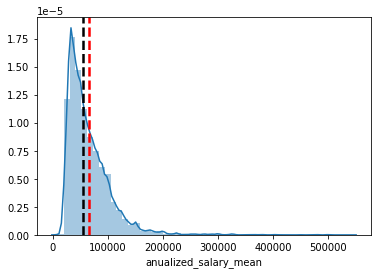

In [19]:
# Show dataset statistics
sal_plot = des_mean_train[des_mean_train["anualized_salary_mean"].notnull()]
print("salary median: ", str(des_mean_train["anualized_salary_mean"].median()))
print("salary mean: ", str(des_mean_train["anualized_salary_mean"].mean()))
ax = sns.distplot(sal_plot["anualized_salary_mean"])
ax.axvline(sal_plot["anualized_salary_mean"].median(), lw=2.5, ls='dashed', color='black')
ax.axvline(sal_plot["anualized_salary_mean"].mean(), lw=2.5, ls='dashed', color='red')
plt.savefig("Distribution.pdf")

In [0]:
# Classify salary values into three classes
des_mean_train["salary_level"] = np.nan
des_mean_train.loc[des_mean_train["anualized_salary_mean"] < 60000, "salary_level"] = 1
des_mean_train.loc[des_mean_train["anualized_salary_mean"] >= 60000, "salary_level"] = 2
des_mean_train.loc[des_mean_train["anualized_salary_mean"] >= 120000, "salary_level"] = 3

# Prepare label dataset
targets = []
for i in range(des_mean_train.shape[0]):
  targets.append(des_mean_train.loc[i]['salary_level'])
value = np.array(targets)

In [0]:
# Transform text data to vectors
# text data consists of description, location, title, and company
des_tr = []

for i in range(des_mean_train.shape[0]):
  text_des=des_mean_train.loc[i]['description']
  text_loc=des_mean_train.loc[i]['location']
  text_tit=des_mean_train.loc[i]['title']
  text_com=des_mean_train.loc[i]['company_name']
  
  # sum_desc=text_des+text_loc+text_tit+text_com
  sum_desc=text_des+" "+text_loc+" "+text_tit+" "+text_com
  clean_des=clean(sum_desc,1)
  des_tr.append(clean_des)

In [0]:
# Transform count vector to tfidf vector
X_counts_des=vect(des_tr, des_tr, 200)

transformer = TfidfTransformer(smooth_idf=False)

tfidf = transformer.fit_transform(X_counts_des)

X_tfidf = tfidf.toarray()

### 0.1 Prepare unlabeled data

In [0]:
# Vectorize unlabeled data
des_all = []

for i in range(df_all.shape[0]):
  text_des=df_all.loc[i]['description']
  text_loc=df_all.loc[i]['location']
  text_tit=df_all.loc[i]['title']
  text_com=df_all.loc[i]['company_name']
  
  sum_desc=text_des+" "+text_loc+" "+text_tit+" "+text_com
  clean_des=clean(sum_desc,1)
  des_all.append(clean_des)

In [0]:
# Transform unlabeled data using tfidf
X_counts_all=vect(des_all, des_tr, 200)

transformer = TfidfTransformer(smooth_idf=False)

tfidf = transformer.fit_transform(X_counts_all)

X_tfidf_all = tfidf.toarray()

# 1 First Layer Models


To Bulid the ensemble model, firstly train three models and tune hyperparameters for later use

### 1.1 Random Forest

In [0]:
def random_forest(features, value):

      clf_rf = RandomForestClassifier()

      score = np.array(features)

      X_train, X_test, y_train, y_test = train_test_split(score, value, train_size = 0.7)

      param_grid = { 
                  "n_estimators"      : [650, 600, 710, 750, 800], 
                  }

      grid_rf = GridSearchCV(clf_rf, param_grid, cv=5)

      grid_rf.fit(X_train, y_train)

      print(grid_rf.best_params_)

      result=grid_rf.predict(X_test)

      print(accuracy_score(y_test, result))

      return grid_rf, grid_rf.best_params_

In [17]:
grid_rf, result_rf = random_forest(X_tfidf, value)

{'n_estimators': 650}
0.8626982513216754


### 1.2 KNN

In [0]:
def KNN(features, value):

      score = np.array(features)

      X_train, X_test, y_train, y_test = train_test_split(score, value, train_size = 0.7)

      neigh = KNeighborsClassifier()

      param_grid = {
            "n_neighbors"       : [2,5,10,20,50,100],
            }

      grid_knn = GridSearchCV(neigh, param_grid, n_jobs = 5, cv=5)

      grid_knn.fit(X_train, y_train)

      print(grid_knn.best_params_)

      result=grid_knn.predict(X_test)

      print(accuracy_score(y_test, result))

      return grid_knn, grid_knn.best_params_

In [30]:
grid_knn, result_knn = KNN(X_tfidf, value)

{'n_neighbors': 2}
0.7968686457909719


### 1.3 SVM

In [0]:
def Sup_vec(features, value):

      clf_sv = SVC()

      score = np.array(features)

      X_train, X_test, y_train, y_test = train_test_split(score, value, train_size = 0.7)

      param_grid = { 
                  "kernel"      : ['poly', 'linear', 'rbf'], 
                  }

      grid_sv = GridSearchCV(clf_sv, param_grid, n_jobs = 5, cv=5)

      grid_sv.fit(X_train, y_train)

      print(grid_sv.best_params_) # poly

      result=grid_sv.predict(X_test)

      print(accuracy_score(y_test, result))

      return grid_sv, grid_sv.best_params_

In [32]:
grid_sv, result_sv = Sup_vec(X_tfidf, value)

{'kernel': 'poly'}
0.8520231801545344


### 1.4 First layer prediction (Baseline models)

In [0]:
# Prepare data for training and scoring models
score = np.array(X_tfidf)
X_train, X_test, y_train, y_test = train_test_split(score, value, train_size = 0.7)

In [0]:
# First layer prediction and scoring models
# The models are also baseline models
neigh = KNeighborsClassifier(n_neighbors=list(result_knn.values())[0])
neigh.fit(X_train, y_train)
result_knn_train=neigh.predict(X_train)
result_knn_test=neigh.predict(X_test)

print("knn done: ", accuracy_score(y_test, result_knn_test))

clf_rf = RandomForestClassifier(n_estimators=list(result_rf.values())[0], random_state=49)
clf_rf.fit(X_train, y_train)
result_rf_train=clf_rf.predict(X_train)
result_rf_test=clf_rf.predict(X_test)

print("random forest done: ", accuracy_score(y_test, result_rf_test))

clf_sv = SVC(kernel=list(result_sv.values())[0])
clf_sv.fit(X_train, y_train)
result_sv_train=clf_sv.predict(X_train)
result_sv_test=clf_sv.predict(X_test)

print("svm done: ", accuracy_score(y_test, result_sv_test))

knn done:  0.7984953233021553
random forest done:  0.8638674257828386
svm done:  0.8542090280601871


In [0]:
# First layer prediction for unlabeled models
result_all_knn=neigh.predict(X_tfidf_all)

print("knn done")

result_all_rf=clf_rf.predict(X_tfidf_all)

print("random forest done")

result_all_sv=clf_sv.predict(X_tfidf_all)

print("svm done")

knn done
random forest done
svm done


In [0]:
# Create new features for next layer prediciton
new_features_all = pd.DataFrame({'KNN_result':result_all_knn,
                                 'RF_result':result_all_rf, 'SVM_result':result_all_sv})

# 2 Second layer model

### 2.1 Train a model for second-layer prediction

In [0]:
# Create features for second layer training
new_features_test = pd.DataFrame({'KNN_result':result_knn_test,
                             'RF_result':result_rf_test, 'SVM_result':result_sv_test})

new_features_train = pd.DataFrame({'KNN_result':result_knn_train,
                             'RF_result':result_rf_train, 'SVM_result':result_sv_train})

In [0]:
# Manually tune hyperparameter for combiner (Random Forest)
best_para=0
best_result=0

for i in range(10,500,5): 
    clf_tune = RandomForestClassifier(n_estimators=i, random_state=49)
    clf_tune.fit(new_features_train, y_train)
    result=clf_tune.predict(new_features_test) 
    accuracy = accuracy_score(y_test, result)
    if accuracy>best_result:
        best_result = accuracy
        best_para=i
        print(best_para," ",best_result)

best_rs=49

for i in range(1,265,1): 
    clf_tune = RandomForestClassifier(n_estimators=best_para, random_state=i)
    clf_tune.fit(new_features_train, y_train)
    result=clf_tune.predict(new_features_test) 
    accuracy = accuracy_score(y_test, result)
    if accuracy>best_result:
        best_result = accuracy
        best_rs=i
        print(best_rs," ",best_result)

clf_best_rf = RandomForestClassifier(n_estimators=best_para, random_state=best_rs)

10   0.862545750305002
15   0.8649349328995527
195   0.8705266368442456


In [0]:
# Manually tune hyperparameter for combiner (KNN)
best_para_knn=0
best_result_knn=0

for i in range(1,10): 

    clf_tune = KNeighborsClassifier(n_neighbors=i)
    clf_tune.fit(new_features_train, y_train)
 
    result=clf_tune.predict(new_features_test) 
    accuracy = accuracy_score(y_test, result)
    if accuracy>best_result_knn:
        best_result_knn = accuracy
        best_para_knn=i
        print(best_para_knn," ",best_result_knn)

for i in range(10,500,10): 

    clf_tune = KNeighborsClassifier(n_neighbors=i)
    clf_tune.fit(new_features_train, y_train)
 
    result=clf_tune.predict(new_features_test) 
    accuracy = accuracy_score(y_test, result)
    if accuracy>best_result_knn:
        best_result_knn = accuracy
        best_para_knn=i
        print(best_para_knn," ",best_result_knn)

clf_best_knn = KNeighborsClassifier(n_neighbors=best_para_knn)

1   0.8634099227328182
230   0.8674766165107768


In [0]:
# Select the best model and score it
if best_result_knn > best_result:
    clf_com = clf_best_knn
else:
    clf_com = clf_best_rf

clf_com.fit(new_features_train, y_train)

print(clf_com.score(new_features_test, y_test))

0.8705266368442456


### 2.2 Second layer prediction

In [0]:
# Prepare second layer features
all_score = np.array(new_features_all)
result=clf_com.predict(all_score)
df_result_all=pd.DataFrame({'Salary_level':result})

In [0]:
# Create new dataframe for result analysis
df_all_pred = pd.concat([df_all, df_result_all, df_final], axis=1, sort=False)
analysis = df_all_pred.loc[:,~df_all_pred.columns.duplicated()]
analysis = analysis.loc[:,['description', 'company_name', 'location', 
                              'title', 'Salary_level', 'score', 'score2']]   

# 3 Result analysis

Use salary and gender scores to analysis the influence of gender languages on job salaries.

### 3.1 Cluster similar categories of jobs

##### 3.1.1 Prepare industry keywords

In [0]:
# Define function to print out different occupation clusters
def print_cluster(maps):
    # print out 10 samples in each industry
    title_pro = {}
    for i in ind_list:
        title_pro[i]=[]

    for i in maps.items():
        title_pro[i[1]].append(i[0])

    ind_number = []
    ind_init = []
    for i in title_pro.items():
        ind_number.append(len(i[1]))
        ind_init.append(i[0][:4])
        print(i[0],"({} entries)".format(len(i[1])))
        print(i[1][200:210])
        
    # plot the distribution of jobs in each industry
    plt.figure(figsize=(8,10)) 
    x = np.arange(len(ind_number))
    plt.title("Baselines performance")
    plt.bar(x, ind_number, width=0.5)
    plt.xticks(x, ind_init)
    plt.savefig('industry.pdf')

In [0]:
# Prepare classification features
big_desc = analysis["description"]
big_title = analysis["title"]

In [41]:
# Prepare a library to classify distinguishi occupations
page = requests.get('https://www.recruiter.com/careers/')
url_list=[]
ind_list=[]
soup = BeautifulSoup(page.text, "html.parser", from_encoding='utf-8')

# Acquire link to different occupations
for div in soup.find_all(name='a', attrs={'class':'c-font-24 c-font-blue-3 c-font-sbold'},href=True):
    url_list.append(div['href'])
    ind_list.append(div.text)

# Get descriptions of different occupations
all_ind_desc=[]
for i in url_list:
    page = requests.get(i)
    time.sleep(random.randint(4,9)/10)
    ind_desc=[]
    soup = BeautifulSoup(page.text, "html.parser", from_encoding='utf-8')
    for div in soup.find_all(name='div', attrs={'class':'careerClusterListDesc'}):
        ind_desc.append(div.text)
    for div in soup.find_all(name='div', attrs={'class':'c-font-16'}):
        ind_desc.append(div.text)
    all_ind_desc.append(ind_desc)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:179: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.")


In [0]:
# Clean text data
text_ind_desc=[]
for i in all_ind_desc:
    text_ind = []
    for j in i:
        if '\n' in j:
            continue
        else:
            text_ind.append(j)
    text_ind_desc.append(text_ind)

In [0]:
# Make a list of keywords from 16 industries
ind_key=[]
for i in text_ind_desc:

    clean_text=[]
    key_words=[]

    for j in i:
        clean_text.append(clean(j,1))
        
    vec = CountVectorizer().fit(clean_text)
    bag_of_words = vec.transform(clean_text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    for i in words_freq[:201]:
        if i[0] != 'may':
            key_words.append(i[0])
    ind_key.append(key_words[:200])

##### 3.1.2 Classify different kinds of jobs

In [93]:
# Classify the job by counting which industry the job description has most keywords of 
ind = []
count=0

start = time.time()
for i in big_desc:

    i = clean(i,1)
    texts=word_tokenize(i) # Tokenize each description

    # Find the industry the job has most keywords of
    scores = []
    for x in ind_key: 
        key_count=0
        max_simialrity=0
        for n in texts:
            if n in x:
                key_count+=1 

        if key_count > max_simialrity:
            max_simialrity = key_count
        scores.append(key_count)
    ind.append(ind_list[scores.index(max(scores))])
    count+=1

    if (count%10000==0):
        print(count)
        end = time.time()
        print(end - start)

end = time.time()
print(end - start)
# Zip the result with job titles
results = dict(zip(big_title,ind))

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://www.google.com/url?q=https://GRYD.formstack.com/forms/2020snljob..." looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


10000
144.05447483062744
20000
293.5507175922394
30000
439.4666495323181
40000
589.0356168746948
50000
731.3151223659515
60000
888.5505321025848
70000
1035.0370545387268
80000
1186.339350938797
90000
1325.2444405555725
100000
1467.6125280857086
110000
1615.578762292862
120000
1764.2212452888489
130000
1910.224997997284
140000
2057.0576543807983
150000
2199.2563016414642
160000
2357.6925418376923
170000
2501.427396774292
180000
2646.770482301712
190000
2793.503100633621
200000
2928.0232169628143
210000
3069.67542886734
220000
3214.4410452842712
230000
3353.9990158081055
240000
3502.2347042560577
250000
3644.229251384735
260000
3787.296413898468
270000
3926.8921105861664
280000
4081.539405107498
4120.61943936348


Agriculture, Food and Natural Resources (1456 entries)
['Highspeed Associate I - Cash Handler', 'Peeler Operator Stick Line', 'General Production Labor 2nd Shift', 'Community Pools Office Assistant', 'Bahama Beach Waterpark Attendant', 'R&D Asst Scientist', 'Cable Splicer - Underground (ONCOR)', 'Laboratory Assistant II', 'Production Crew', 'Plant Manager - Steel Fabrication']
Architecture and Construction (1789 entries)
['Journeyman Labor', 'General Labor Associate- $15/hr', 'Equipment Operator - Overhead (ONCOR)', '7620.PLUMBER.N/A.MAIN(965-MAINT & FAC SRV)', 'Current Job Openings', 'COMBINATION INSPECTOR', 'Property Preservation Subcontractors', 'Concrete Laborer and Finisher', 'Millwright', 'Software Consultant']
Arts, Audio/Video Technology and Communications (1393 entries)
['Nuke Artist', 'Corporate Recruiter', 'FX TD', 'Character Designer', 'Audio Technician, Screening Operations', 'TV Lighting TD', 'Talent Relations Manager', 'Creator Relations Associate', 'Publicity Specialist

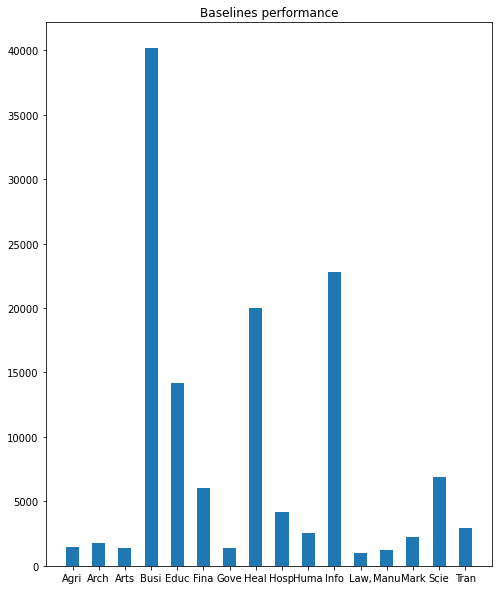

In [98]:
# Print out the results
print_cluster(results)

In [0]:
# Put the results into the dataframe to create a new dataset
dict_new = {}
lst=[]
for i in results.items():
    lst.append([i[0],i[1]])

value=[]
key=[]
for i in lst:
    value.append(i[0])
    key.append(i[1])
dict_new['industry']=key
dict_new['title']=value

job_class = pd.DataFrame(dict_new)

analysis_new = analysis.join(job_class.set_index('title'), on='title')

### 3.2 Analyze statistics


In [0]:
# Define function to calculate confidence interval
def conf_int(scores):

    confidence = 0.95
    data = scores

    n = len(data)
    m = mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)

    start = m - h
    end = m + h

    return([m, h])

In [0]:
# Take out relevant features for analysis
jobs = analysis_new.loc[:,['industry', 'Salary_level', 'score', 'score2', 'location']]

In [49]:
# Computing and storing gender scores of different industries
score_1s=[]
score_2s=[]
for i in ind_list:
    jobs_ind=jobs[jobs.industry == i]
    score1_ci = conf_int(jobs_ind['score'])
    score2_ci = conf_int(jobs_ind['score2'])
    salary_ci = conf_int(jobs_ind['Salary_level'])

    # Compute confidence interval
    ci_1 = [score1_ci[0]-score1_ci[1], score1_ci[0], score1_ci[0]+score1_ci[1]]
    ci_2 = [score2_ci[0]-score2_ci[1], score2_ci[0], score2_ci[0]+score2_ci[1]]

    score_1s.append([i,ci_1[0]])
    score_1s.append([i,ci_1[1]])
    score_1s.append([i,ci_1[2]])

    score_2s.append([i,ci_2[0]])
    score_2s.append([i,ci_2[1]])
    score_2s.append([i,ci_2[2]])

    print(i, ':\n', "(score1: %.3f±%.3f, score2: %.3f±%.3f, salary: %.3f±%.3f"
          % (score1_ci[0], score1_ci[1], score2_ci[0], score2_ci[1], salary_ci[0] 
          ,salary_ci[1]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  import sys


Agriculture, Food and Natural Resources :
 (score1: 0.402±0.012, score2: -0.239±0.029, salary: 1.257±0.017
Architecture and Construction :
 (score1: 0.381±0.011, score2: -0.275±0.026, salary: 1.167±0.014
Arts, Audio/Video Technology and Communications :
 (score1: 0.384±0.012, score2: -0.256±0.029, salary: 1.424±0.019
Business Management and Administration :
 (score1: 0.419±0.002, score2: -0.180±0.005, salary: 1.444±0.003
Education and Training :
 (score1: 0.407±0.004, score2: -0.206±0.010, salary: 1.456±0.007
Finance :
 (score1: 0.519±0.006, score2: 0.046±0.014, salary: 1.558±0.009
Government and Public Administration :
 (score1: 0.441±0.013, score2: -0.142±0.031, salary: 1.360±0.019
Health Science :
 (score1: 0.396±0.004, score2: -0.231±0.009, salary: 1.371±0.005
Hospitality and Tourism :
 (score1: 0.316±0.006, score2: -0.428±0.013, salary: 1.066±0.005
Human Services :
 (score1: 0.321±0.009, score2: -0.388±0.021, salary: 1.259±0.013
Information Technology :
 (score1: 0.508±0.004, scor

In [0]:
# Save the results to csv
df_score1_ind = pd.DataFrame(score_1s).rename(columns={0: 'industry', 1:'score'})
df_score1_ind.to_csv("score1_ind.csv")
df_score2_ind = pd.DataFrame(score_2s).rename(columns={0: 'industry', 1:'score'})
df_score2_ind.to_csv("score2_ind.csv")

In [69]:
# Computing and storing gender scores of different salary levels
score_1s=[]
score_2s=[]
Salary_levels = ["Low salary", "Medium salary", "High salary"]
for i in [1,2,3]:
    jobs_ind=jobs[jobs.Salary_level == i]
    score1_ci = conf_int(jobs_ind['score'])
    score2_ci = conf_int(jobs_ind['score2'])

    # Compute confidence interval
    ci_1 = [score1_ci[0]-score1_ci[1], score1_ci[0], score1_ci[0]+score1_ci[1]]
    ci_2 = [score2_ci[0]-score2_ci[1], score2_ci[0], score2_ci[0]+score2_ci[1]]

    score_1s.append([Salary_levels[i-1],ci_1[0]])
    score_1s.append([Salary_levels[i-1],ci_1[1]])
    score_1s.append([Salary_levels[i-1],ci_1[2]])

    score_2s.append([Salary_levels[i-1],ci_2[0]])
    score_2s.append([Salary_levels[i-1],ci_2[1]])
    score_2s.append([Salary_levels[i-1],ci_2[2]])
    print(i, ':\n', "(score1: %.3f±%.3f, score2: %.3f±%.3f"
          % (score1_ci[0], score1_ci[1], score2_ci[0], score2_ci[1]))

1 :
 (score1: 0.359±0.002, score2: -0.314±0.004
2 :
 (score1: 0.516±0.002, score2: 0.033±0.005
3 :
 (score1: 0.510±0.010, score2: 0.020±0.024


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead
  import sys


In [0]:
# Save the results to csv
df_score1_sal = pd.DataFrame(score_1s).rename(columns={0: 'salary', 1:'score'})
df_score1_sal.to_csv("score1_sal.csv")
df_score2_sal = pd.DataFrame(score_2s).rename(columns={0: 'salary', 1:'score'})
df_score2_sal.to_csv("score2_sal.csv")